In [1]:
%load_ext autoreload
%autoreload 2

from src import *
import torch
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import os

#torch.autograd.set_detect_anomaly(True) 

/root/circuit_breaking/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Model & Dataset

In [2]:
llama_size = "7b"
use_base_model = True

if not use_base_model:
    model_name_or_path = f"meta-llama/Llama-2-{llama_size}-chat-hf"
else:
    model_name_or_path = f"meta-llama/Llama-2-{llama_size}-hf"

hf_model, hf_tokenizer = load_model_from_transformers(model_name_or_path)
model = from_hf_to_tlens(hf_model, hf_tokenizer, f"llama-{llama_size}", disable_grads=True)

Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.72s/it]


Loaded pretrained model llama-7b into HookedTransformer
Moving model to device:  cuda


In [3]:
forget_dataset, forget_dataloader = create_dataset("harry_potter", model.tokenizer, batch_size=32, max_seq_length=1024)
retain_dataset, retain_dataloader = create_dataset("owt", model.tokenizer, batch_size=32, max_seq_length=512, num_examples=1000)

/root/circuit_breaking/.venv/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


### Train Mask


In [4]:
mask = SVDMask(model).cuda()

train_mask(
    model=model,
    mask=mask,
    retain_dataloader=retain_dataloader,
    forget_dataloader=forget_dataloader,
    max_gpu_batch_size=4,
    learning_rate=1e-1,
)

torch.Size([4096, 4096])
torch.Size([4096, 4096])
torch.Size([4096, 4096])
torch.Size([4096, 4096])
torch.Size([4096, 4096])
torch.Size([4096, 4096])
torch.Size([4096, 4096])
torch.Size([4096, 4096])
torch.Size([4096, 4096])
torch.Size([4096, 4096])
torch.Size([4096, 4096])
torch.Size([4096, 4096])
torch.Size([4096, 4096])
torch.Size([4096, 4096])
torch.Size([4096, 4096])
torch.Size([4096, 4096])
torch.Size([4096, 4096])
torch.Size([4096, 4096])
torch.Size([4096, 4096])
torch.Size([4096, 4096])
torch.Size([4096, 4096])
torch.Size([4096, 4096])
torch.Size([4096, 4096])
torch.Size([4096, 4096])
torch.Size([4096, 4096])
torch.Size([4096, 4096])
torch.Size([4096, 4096])
torch.Size([4096, 4096])
torch.Size([4096, 4096])
torch.Size([4096, 4096])
torch.Size([4096, 4096])
torch.Size([4096, 4096])


Retain Loss: 1.922, Forget Loss: 0.027, Reg Loss: 0.055: 100%|██████████| 50/50 [05:53<00:00,  7.07s/it]


### Analyze mask

In [5]:
# Compute metrics for different threshold levels
change_over_time = []

for threshold in np.linspace(0, 1, 15):
    mask.discretize_threshold(threshold)
    print(mask.num_masked())
    forget_results = compute_metrics(model, forget_dataloader, verbose=False)
    retain_results = compute_metrics(model, retain_dataloader, verbose=False)
    change_over_time.append((forget_results, retain_results))


0
1
1
1
4
8
12
24
47
104
180
327
605
1043
131072


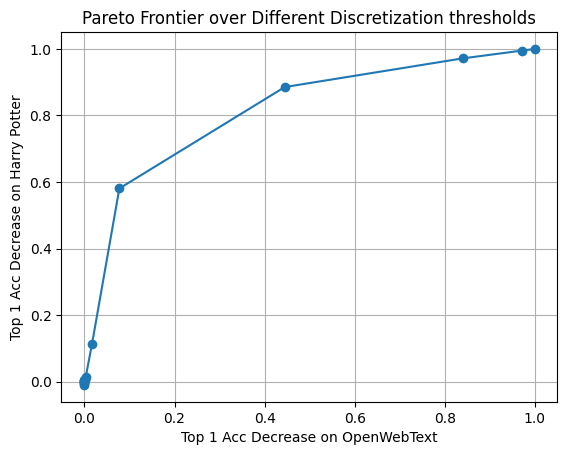

In [6]:
# Generate pareto plot using results

initial_x = change_over_time[0][0]["summary"]["top1_acc"]
initial_y = change_over_time[0][1]["summary"]["top1_acc"]

points = []

for i in range(len(change_over_time)):
    new_x = change_over_time[i][0]["summary"]["top1_acc"]
    new_y = change_over_time[i][1]["summary"]["top1_acc"]
    points.append(( (initial_x - new_x)/initial_x, (initial_y - new_y)/initial_y ))
    
points = np.array(points)

plt.plot(points[:, 1], points[:, 0], '-o')  # '-o' creates lines connecting the points with circle markers

# Label the axes
plt.xlabel("Top 1 Acc Decrease on OpenWebText")
plt.ylabel("Top 1 Acc Decrease on Harry Potter")

# Optional: Add a title
plt.title("Pareto Frontier over Different Discretization thresholds")

# Show grid to better visualize the trade-offs
plt.grid(True)

# Show the plot
plt.show()

In [7]:
for i in range(len(change_over_time)):
    forget_acc = change_over_time[i][0]["summary"]["top1_acc"]
    retain_acc = change_over_time[i][1]["summary"]["top1_acc"]
    print(forget_acc, retain_acc)

0.7594496607780457 0.5664238487520525
0.7584418058395386 0.5668008250574912
0.7632976770401001 0.5671841252234674
0.7629738648732504 0.5667862334559041
0.7668834726015726 0.5664114759814355
0.7553428212801615 0.5668683763473265
0.7578526735305786 0.5672531916249183
0.7554338375727335 0.5660985996646266
0.7478591005007426 0.564763892081476
0.6725511948267618 0.5568664054716786
0.31848577161629993 0.5225523671796245
0.08706424633661906 0.314536246561235
0.02161567782362302 0.09066371811974433
0.00374531839042902 0.015655091933665738
0.0 0.0


In [8]:
# Compute metrics for different threshold levels
change_over_time = []

for topk in [0, 100, 250, 500, 750, 800, 900, 1_000, 1_500, 2_000]:        
    mask.discretize_topk(topk)
    print(mask.num_masked())
    forget_results = compute_metrics(model, forget_dataloader, verbose=False)
    retain_results = compute_metrics(model, retain_dataloader, verbose=False)
    change_over_time.append((forget_results, retain_results))

# Generate pareto plot using results

initial_x = change_over_time[0][0]["summary"]["top1_acc"]
initial_y = change_over_time[0][1]["summary"]["top1_acc"]

points = []

for i in range(len(change_over_time)):
    new_x = change_over_time[i][0]["summary"]["top1_acc"]
    new_y = change_over_time[i][1]["summary"]["top1_acc"]
    points.append(( (initial_x - new_x)/initial_x, (initial_y - new_y)/initial_y ))
    
points = np.array(points)

plt.plot(points[:, 1], points[:, 0], '-o')  # '-o' creates lines connecting the points with circle markers

# Label the axes
plt.xlabel("Top 1 Acc Decrease on OpenWebText")
plt.ylabel("Top 1 Acc Decrease on Harry Potter")

# Optional: Add a title
plt.title("Pareto Frontier over Different Discretization thresholds")

# Show grid to better visualize the trade-offs
plt.grid(True)

# Show the plot
plt.show()



0


100
250
500


In [ ]:
for i in range(len(change_over_time)):
    forget_acc = change_over_time[i][0]["summary"]["top1_acc"]
    retain_acc = change_over_time[i][1]["summary"]["top1_acc"]
    print(forget_acc, retain_acc)

0.7549053827921549 0.5663473894519191
0.7308651606241862 0.5643101526844886
0.41501444578170776 0.5528303865463503
0.045809159676233925 0.3099187852874879
0.0 0.00031342346436201386
0.0 0.00016225415944767695
0.0 4.4399876646967905e-06
0.0 1.30781028870373e-05
0.0 0.0
0.0 0.0


In [ ]:
change_over_time[i][0]["summary"]

{'loss_mean': 14.416666666666666,
 'loss_var': 0.011284722222222224,
 'top1_acc': 0.0,
 'top1_var': 0.0}

In [ ]:
torch.kthvalue(torch.tensor([0, 1, 2, 4, ][::-1]), 4).values

tensor(4)